# UMA Raw data EDA

## Import Libraries

In [90]:
# analysis
import numpy as np
import pandas as pd
import requests

# other
import warnings

# visualisation libraries
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns

# Notebook styling
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
warnings.filterwarnings("ignore")


## Import Data

In [91]:
task = {"username": "gometro-system-admin",
        "password": "3P6VP3ekMlPdi0IGM8VjJ6lEdZTNIuvR",
        "client_id": "gometro-uma-service",
        "grant_type": "password",
       }

endpoint = 'https://identity.gometroapp.com/auth/realms/platform/protocol/openid-connect/token'
resp = requests.post(endpoint, data=task)

if (resp.status_code < 200) and (resp.status_code >= 300):
    raise ValueError('POST /tasks/ {}'.format(resp.status_code))
    
token = resp.json()["access_token"]

headers = {
    'Authorization': f'Bearer {token}',
}
endpoint = 'https://api.gometroapp.com/uma/v1/participants/e8370867-30ce-475a-a444-2bcd1cc321d3/events/2021-01-14'
response = requests.get(endpoint, headers=headers)

In [92]:
import pandas as pd
df_api = pd.DataFrame(response.json())
print(df_api.shape)
df_api.head()

(2338, 3)


timestamp                   type  \
0  2021-01-12T02:57:07.395Z    MemoryStatusChanged   
1  2021-01-12T02:58:07.395Z    MemoryStatusChanged   
2  2021-01-12T02:59:07.396Z    MemoryStatusChanged   
3  2021-01-12T02:59:52.575Z  DeviceSettingsUpdated   
4  2021-01-12T03:00:07.397Z    MemoryStatusChanged   

                                             payload  
0  {"availableMemory":424243200,"lowMemory":false...  
1  {"availableMemory":421408768,"lowMemory":false...  
2  {"availableMemory":420646912,"lowMemory":false...  
3  {"settings":[null,null,null,null,null,{"name":...  
4  {"availableMemory":418246656,"lowMemory":false...

## Assess Data

Assessing the event types we are receiving from the API

In [93]:
print(f"Number of categories: {len(df['type'].unique())}")
df['type'].value_counts()

Number of categories: 5


MemoryStatusChanged       1440
LocationChanged            455
DeviceSettingsUpdated      288
SatelliteStatusChanged     131
Warning                     24
Name: type, dtype: int64

Let us look at the payloads of the different `type` categories.

In [94]:
for category in df['type'].unique():
    print(category)
    print(df[df['type'] == category].iloc[0,2], '\n')

MemoryStatusChanged
{"availableMemory":424243200,"lowMemory":false,"threshold":150994944,"totalMemory":989736960} 

DeviceSettingsUpdated
{"settings":[null,null,null,null,null,{"name":"tracking.enabled","stringValue":"true","type":"BOOLEAN","lastModified":0,"serializable":true,"externalizable":true},{"name":"core.debug","stringValue":"false","type":"BOOLEAN","lastModified":0,"serializable":true,"externalizable":true,"mutable":false}]} 

SatelliteStatusChanged
{"satelliteCount":10} 

LocationChanged
{"provider":"gps","latitude":-33.868675,"longitude":18.53884833333333,"accuracy":2.5999999046325684,"bearing":319.80999755859375,"speed":0} 

Warning
{"message":"[DeviceEventsService.flush] Network Unavailable"} 



**Data Dictionary**

* `timestamp`: date and time waypoint was captured, UTC Timezome
* `type`: indicates the type of data contained in the payload
    * `LocationChanged`: Labels data with geographical observations in the payload
    * `SatelliteStatusChanged`: Labels data with the number of satellites connected to device
* `payload`: the payload of the data


The data required for this exercise is the data containing the waypoints, which is where the `type` category is `LocationChanged`

In [95]:
df_waypoints = df[
    df['type'] == 'LocationChanged'
]
print(df_waypoints.shape)
df_waypoints.head()

(455, 3)


timestamp             type  \
9   2021-01-12T03:03:35Z  LocationChanged   
16  2021-01-12T03:07:30Z  LocationChanged   
19  2021-01-12T03:09:39Z  LocationChanged   
30  2021-01-12T03:17:46Z  LocationChanged   
35  2021-01-12T03:21:04Z  LocationChanged   

                                              payload  
9   {"provider":"gps","latitude":-33.868675,"longi...  
16  {"provider":"gps","latitude":-33.8687266666666...  
19  {"provider":"gps","latitude":-33.8686466666666...  
30  {"provider":"gps","latitude":-33.8687233333333...  
35  {"provider":"gps","latitude":-33.8687250000000...

In [96]:
def unpack_payload(df, payload_col = 'payload'):
    
    """
    This function takes a dataframe where the payload is in one column
    and creates a new column for each element in the payload
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with payload
        payload_col (str): column name of field containing the payload of the data
    
    Returns: (pandas.DataFrame): Dataframe with payload data in each column
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # import literal_eval function
    from ast import literal_eval

    # make list of column headers from keys
    payload_cols = literal_eval(df['payload'].iloc[0]).keys()
    
    # add columns for each column header to dataframe
    for col in payload_cols:
        df[col] = df_waypoints['payload'].apply(lambda x: literal_eval(x)[col])
        
    # remove type and payload column
    df.drop(['type', 'payload'], axis=1, inplace=True)
    
    return df



Unpacking the payload and updating the table

In [97]:
df_waypoints = unpack_payload(df_waypoints)
print(df_waypoints.shape)
df_waypoints.head()

(455, 7)


timestamp provider   latitude  longitude  accuracy     bearing  \
9   2021-01-12T03:03:35Z      gps -33.868675  18.538848       2.6  319.809998   
16  2021-01-12T03:07:30Z      gps -33.868727  18.538848       2.7  174.240005   
19  2021-01-12T03:09:39Z      gps -33.868647  18.538888       3.0  210.520004   
30  2021-01-12T03:17:46Z      gps -33.868723  18.538930       1.8   23.870001   
35  2021-01-12T03:21:04Z      gps -33.868725  18.538823       2.2  250.300003   

       speed  
9   0.000000  
16  0.117357  
19  0.000000  
30  0.028824  
35  0.407145

Data types and null values

In [98]:
df_waypoints.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455 entries, 9 to 2331
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  455 non-null    object 
 1   provider   455 non-null    object 
 2   latitude   455 non-null    float64
 3   longitude  455 non-null    float64
 4   accuracy   455 non-null    float64
 5   bearing    455 non-null    float64
 6   speed      455 non-null    float64
dtypes: float64(5), object(2)
memory usage: 28.4+ KB


## Univariate Analysis

1. Categorical variables
1. Numerical variables

### Categorical variables

1. `timestamps`
2. `provider`

Assessing `timestamps`

In [99]:
df_waypoints['timestamp'].value_counts()

2021-01-12T12:11:20Z    1
2021-01-12T09:35:37Z    1
2021-01-12T11:05:28Z    1
2021-01-12T11:25:39Z    1
2021-01-12T09:34:26Z    1
                       ..
2021-01-12T23:26:56Z    1
2021-01-12T11:00:54Z    1
2021-01-12T09:02:34Z    1
2021-01-12T11:16:09Z    1
2021-01-12T10:58:51Z    1
Name: timestamp, Length: 455, dtype: int64

In [100]:
df_waypoints['timestamp'] = pd.to_datetime(df_waypoints['timestamp'])
df_waypoints['timestamp'].head()

9    2021-01-12 03:03:35+00:00
16   2021-01-12 03:07:30+00:00
19   2021-01-12 03:09:39+00:00
30   2021-01-12 03:17:46+00:00
35   2021-01-12 03:21:04+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

In [101]:
# df_waypoints['time'] = df_waypoints['timestamp'].dt.time
# df_waypoints['time']

In [102]:
df_waypoints = df_waypoints.set_index('timestamp')
df_waypoints.head()

provider   latitude  longitude  accuracy  \
timestamp                                                            
2021-01-12 03:03:35+00:00      gps -33.868675  18.538848       2.6   
2021-01-12 03:07:30+00:00      gps -33.868727  18.538848       2.7   
2021-01-12 03:09:39+00:00      gps -33.868647  18.538888       3.0   
2021-01-12 03:17:46+00:00      gps -33.868723  18.538930       1.8   
2021-01-12 03:21:04+00:00      gps -33.868725  18.538823       2.2   

                              bearing     speed  
timestamp                                        
2021-01-12 03:03:35+00:00  319.809998  0.000000  
2021-01-12 03:07:30+00:00  174.240005  0.117357  
2021-01-12 03:09:39+00:00  210.520004  0.000000  
2021-01-12 03:17:46+00:00   23.870001  0.028824  
2021-01-12 03:21:04+00:00  250.300003  0.407145

Assessing `provider`

In [103]:
df_waypoints['provider'].value_counts()

gps    455
Name: provider, dtype: int64

In [104]:
df_waypoints['provider'].value_counts(normalize=True)

gps    1.0
Name: provider, dtype: float64

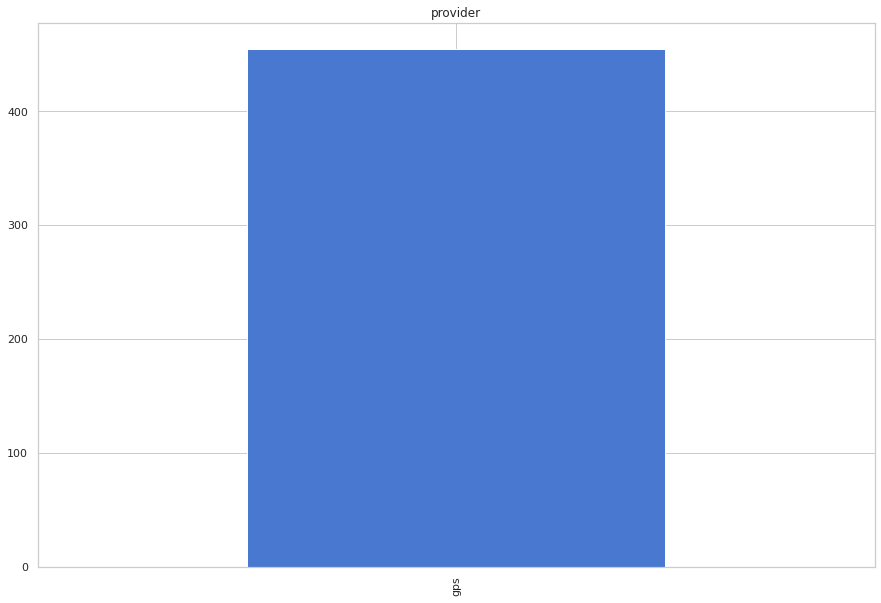

In [105]:
# column to visualise
col = 'provider'

df_waypoints[col].value_counts().plot(kind='bar')
plt.title(col)
plt.show()


### Numerical variables

1. `accuracy`
1. `bearing`
1. `speed`

In [106]:
df_waypoints.describe().drop(['latitude', 'longitude'], axis=1)

accuracy     bearing       speed
count  455.000000  455.000000  455.000000
mean     2.885714  188.928132    6.543394
std      1.044196  105.297272    6.356476
min      1.000000    2.480000    0.000000
25%      2.300000   92.500000    0.144894
50%      2.700000  186.190002    5.008247
75%      3.100000  261.319992   12.114502
max      9.900000  359.239990   22.289017

Assessing `accuracy`

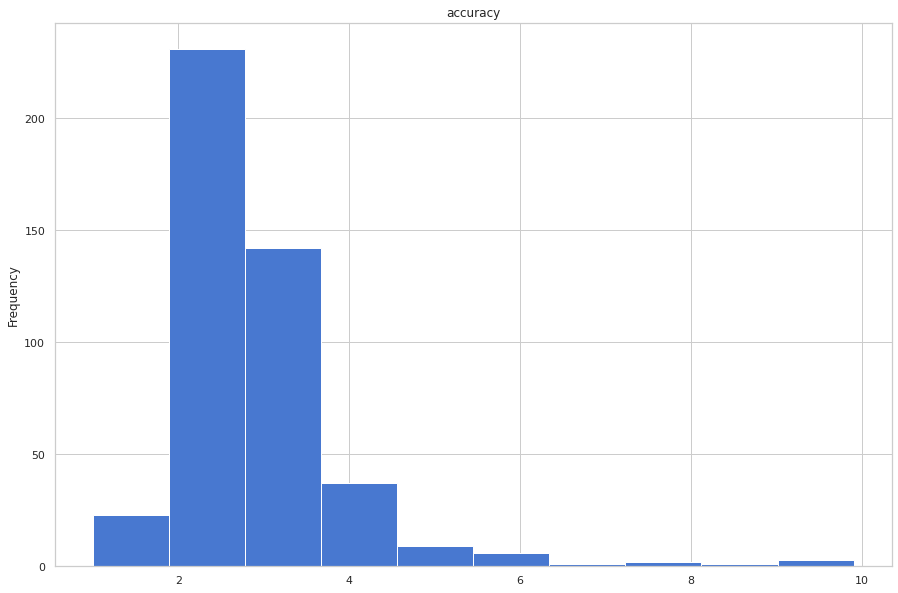

In [107]:
# column to visualise
col = 'accuracy'

df_waypoints[col].plot(kind='hist')
plt.title(col)
plt.show()

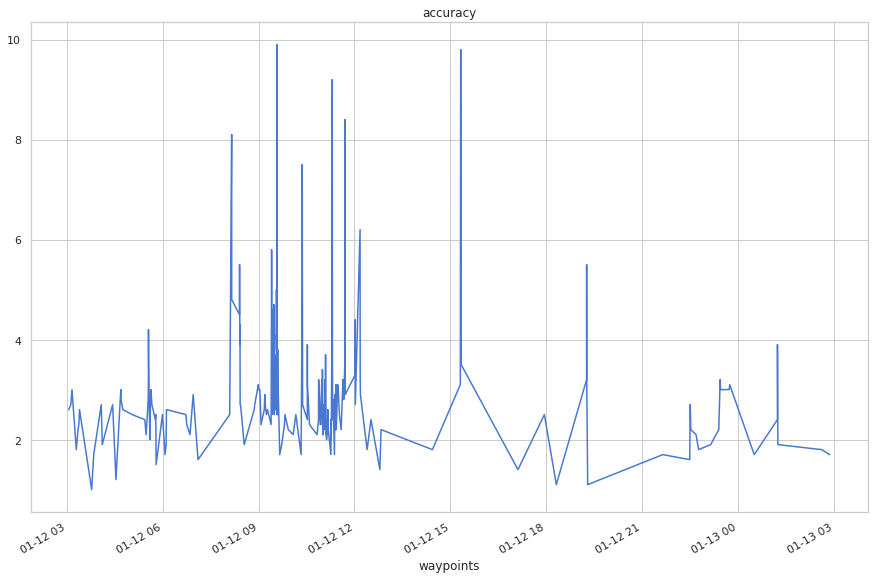

In [108]:
df_waypoints[col].plot(kind='line')
plt.title(col)
plt.xlabel('waypoints')
plt.show()

Assessing `bearing`

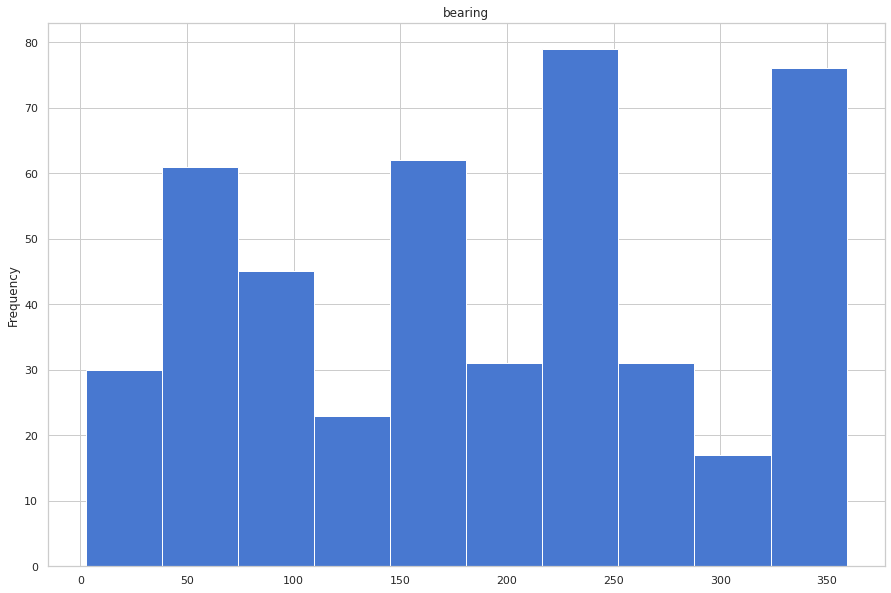

In [109]:
# column to visualise
col = 'bearing'

df_waypoints[col].plot(kind='hist')
plt.title(col)
plt.show()

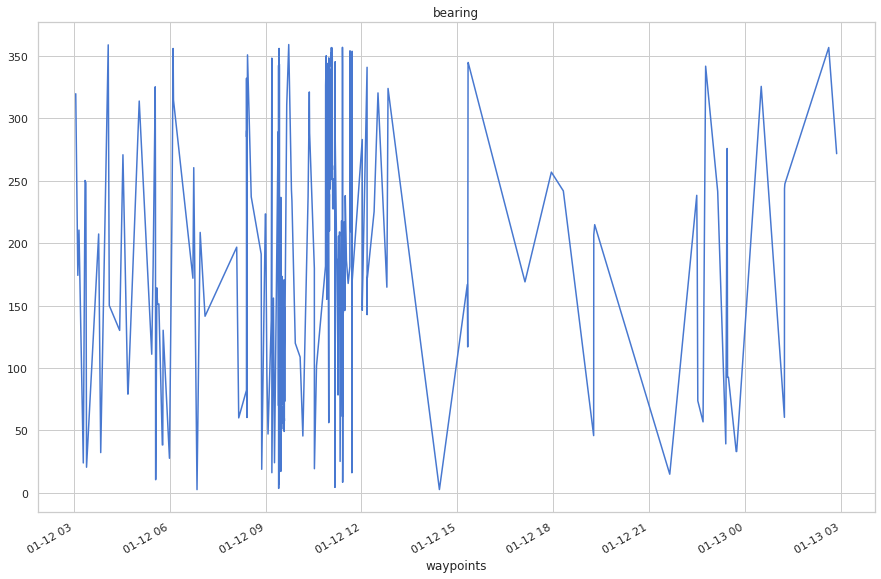

In [110]:
df_waypoints[col].plot(kind='line')
plt.title(col)
plt.xlabel('waypoints')
plt.show()

Assessing `speed`

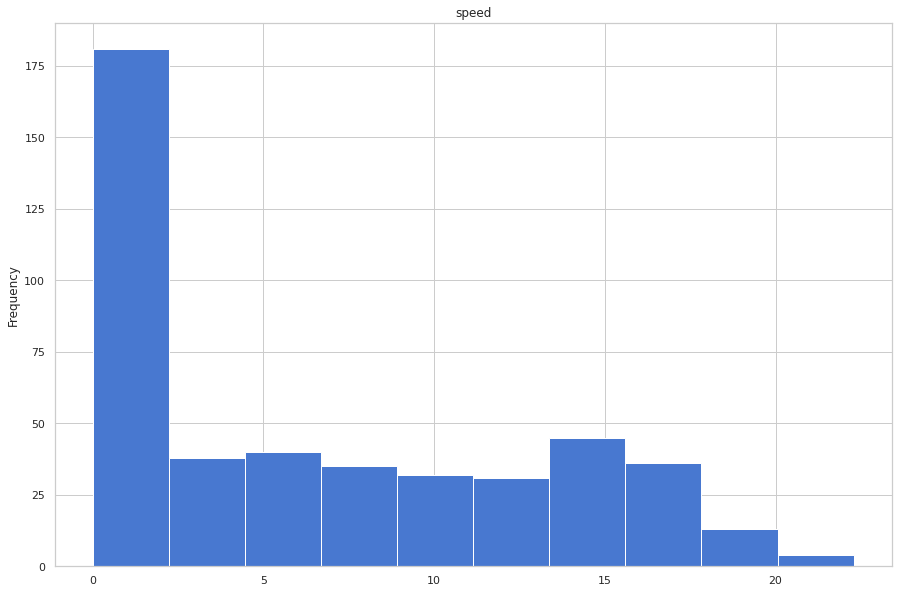

In [111]:
# column to visualise
col = 'speed'

df_waypoints[col].plot(kind='hist')
plt.title(col)
plt.show()

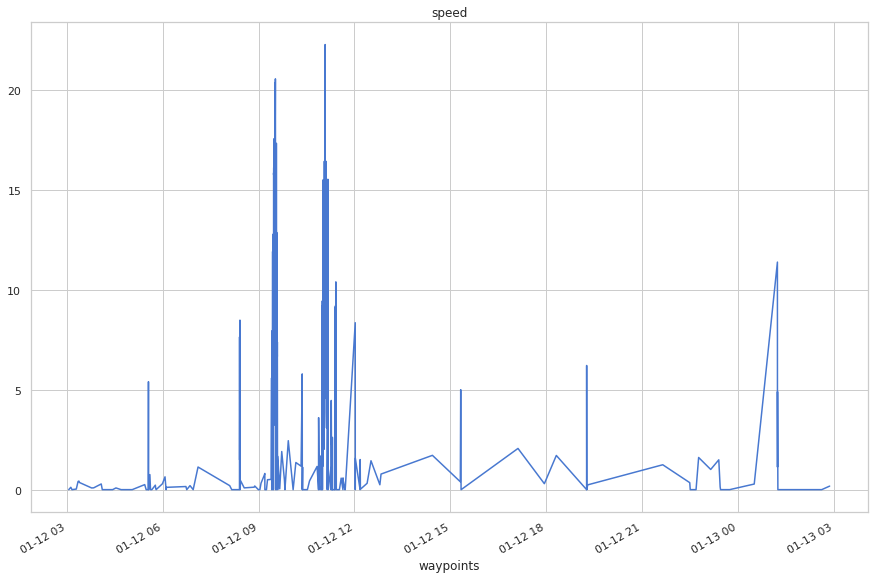

In [112]:
df_waypoints[col].plot(kind='line')
plt.title(col)
plt.xlabel('waypoints')
plt.show()

In [113]:
def add_label_units(label):
    """
    This function generates a label with units
    ------------------------------------
    Parameters:
        label (str): column name of field we want units for
    
    Returns:
        (str): column name of field with the units such that '<label> (<unit>)'
    ------------------------------------
    Example:
    
    """
    
    # define dictionary of units for known column names
    units_dict = {'speed': 'm/s',
                  'acceleration': 'm/$s^{2}$',
                  'cumm_acceleration': 'm/$s^{2}$',
                  'bearing': '$&deg;$',
                  'latitude': '$&deg;$',
                  'longitude': '$&deg;$',
                  'accuracy': 'm',
                  'distance': 'm'
                  }
    
    # return units for known column names
    if label in units_dict.keys():
        return f'{label} [{units_dict[label]}]'
    
    # return label for unknown colum names
    return label

In [114]:
def raw_trip_analysis_plot(df, col, participant_id, date,
                           figures_dir='../../resources/reports/figures/raw_data_viz/'):
    
    # 1. set size of figure
    fig, ax = plt.subplots(figsize=(400,10))
    
    
    # 2. plot figure
    ax.plot(df_waypoints.loc[date][col], linestyle='-', color='b')

                        
    # 3. format figure
    # 3.1 set title of figure
    ax.set_title(f"{col} profile over time on {date}")
    
    # 3.2 set y_label
    ax.set_ylabel(add_label_units(col))
    
    # 3.3 set x_label
    ax.set_xlabel('time [24hrs]')
    
    # 3.4 set x-axis ticks to 1 min intervals
    xlocator = mdates.MinuteLocator(interval = 1)
    ax.xaxis.set_major_locator(xlocator)
    
    ## Format xtick labels as HH:MM
    xformatter = mdates.DateFormatter('%H:%M')
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    
    # plt.xticks(rotation=90)
    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')
    
    # 4. define path
    file_path = f"{figures_dir}{participant_id}/{date}_{col}_vs_time"
    
    # 5 save figure
    plt.savefig(file_path)
    
    # 6 display figure
    plt.show()

Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]),

Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1365 ticks ([18639.084722222222, ..., 18640.031944444443]),

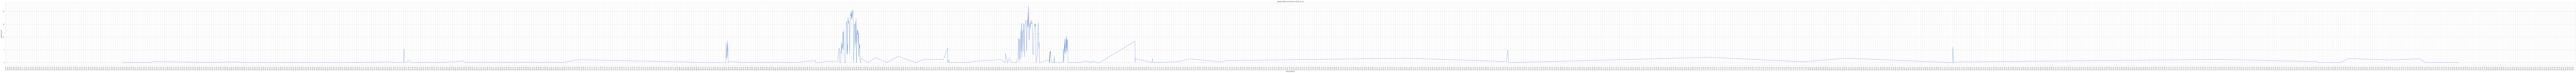

In [115]:
raw_trip_analysis_plot(df_waypoints, 'speed', '9c3e37e8-5b51-463c-8688-4452e0c39dbf', '2021-01-12', '')